In [1]:
import os 
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter, FuncFormatter

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [2]:
# set paths and create dirs 
base_dir = '../..'
data_dir = os.path.join(base_dir, 'data')
helper_dir = os.path.join(base_dir, 'helper')
output_dir = os.path.join(base_dir, 'output')
png_dir = os.path.join(output_dir, 'png')
os.makedirs(png_dir, exist_ok=True)

In [3]:
# load helper functions
%run {helper_dir}/mk_design_matrix.py
%run {helper_dir}/plot.py
%run {helper_dir}/fit_data.py

## Input

In [4]:
chain = 'Avalanche'

In [5]:
data_fnames = os.listdir(os.path.join(data_dir, chain)) # names of all data files

# collect the names of the files for this analysis
fnames = dict()
for fname in data_fnames:
    if fname.startswith('Fees'):
        fnames['Fees'] = fname
    if fname.startswith('Volume'):
        fnames['Volume'] = fname
fnames

{'Volume': 'Volume_2022-01-06_2022-07-01.csv',
 'Fees': 'Fees_2022-01-06_2022-07-01.csv'}

In [6]:
# create input-dependent dirs
save_fig_dir = os.path.join(png_dir, chain)
os.makedirs(save_fig_dir, exist_ok=True)

## Prep Data

In [7]:
# read daily data
lst_of_dfs = []
for key, fname in fnames.items():
    # only read the first 7 cols since the last col "Cumulative" is NOT the daily total, but cumulative daily total, 
    # which we don't want.
    df = pd.read_csv(os.path.join(data_dir, chain, fname), parse_dates=['Date'], index_col='Date', usecols=range(6))
    df.columns = df.columns.str.lower().str.replace(' ', '_') + '_{}'.format(key.lower())
    # calc daily total 
    df['total_{}'.format(key.lower())] = df.sum(axis=1)
    lst_of_dfs.append(df)
del df

df_daily = pd.concat(lst_of_dfs, axis=1)    
df_daily.info()    

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 177 entries, 2022-01-06 to 2022-07-01
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   swap_volume            177 non-null    float64
 1   margin_trading_volume  177 non-null    float64
 2   mint_glp_volume        177 non-null    float64
 3   burn_glp_volume        177 non-null    float64
 4   liquidation_volume     177 non-null    float64
 5   total_volume           177 non-null    float64
 6   swap_fees              177 non-null    float64
 7   margin_trading_fees    177 non-null    float64
 8   mint_glp_fees          177 non-null    float64
 9   burn_glp_fees          177 non-null    float64
 10  liquidation_fees       177 non-null    float64
 11  total_fees             177 non-null    float64
dtypes: float64(12)
memory usage: 18.0 KB


In [8]:
# drop the last row because the most recent date may not be a full day
df_daily = df_daily.iloc[:-1, :]
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 176 entries, 2022-01-06 to 2022-06-30
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   swap_volume            176 non-null    float64
 1   margin_trading_volume  176 non-null    float64
 2   mint_glp_volume        176 non-null    float64
 3   burn_glp_volume        176 non-null    float64
 4   liquidation_volume     176 non-null    float64
 5   total_volume           176 non-null    float64
 6   swap_fees              176 non-null    float64
 7   margin_trading_fees    176 non-null    float64
 8   mint_glp_fees          176 non-null    float64
 9   burn_glp_fees          176 non-null    float64
 10  liquidation_fees       176 non-null    float64
 11  total_fees             176 non-null    float64
dtypes: float64(12)
memory usage: 17.9 KB


In [9]:
# make linear trend features
X_daily = mk_X_linear_trend(df_daily.index)
X_daily.head()

,trend
Date,
2022-01-06,1.0000
2022-01-07,2.0000
2022-01-08,3.0000
2022-01-09,4.0000
2022-01-10,5.0000


In [10]:
# roll up to weekly level
df_weekly = df_daily.groupby(df_daily.index.to_period('W')).sum()
df_weekly.index.name = 'Week'
df_weekly.head()

,swap_volume,margin_trading_volume,mint_glp_volume,burn_glp_volume,liquidation_volume,total_volume,swap_fees,margin_trading_fees,mint_glp_fees,burn_glp_fees,liquidation_fees,total_fees
Week,,,,,,,,,,,,
2022-01-03/2022-01-09,"17,702,323.2168","95,229,525.2260","24,217,055.9725","2,283,523.2752","944,090.2957","140,376,517.9862","34,603.1550","102,575.2151","60,590.4614","2,286.6139","1,879.1480","201,934.5933"
2022-01-10/2022-01-16,"49,311,762.3982","580,752,449.5723","31,020,026.2097","8,040,568.5156","539,390.7775","669,664,197.4733","86,569.1016","656,141.2356","48,414.9200","7,183.0133","1,177.9706","799,486.2410"
2022-01-17/2022-01-23,"114,573,242.6424","932,641,356.2994","31,559,348.8833","22,410,928.4886","3,490,553.4661","1,104,675,429.7798","214,932.2786","1,063,611.9153","38,717.0491","33,602.5833","11,896.9865","1,362,760.8128"
2022-01-24/2022-01-30,"56,834,477.2397","687,958,100.8870","35,139,593.0586","13,119,797.9622","743,505.8006","793,795,474.9481","114,668.9074","779,951.6599","50,696.3476","22,384.1124","2,057.4029","969,758.4302"
2022-01-31/2022-02-06,"81,689,008.4207","590,810,562.3242","34,873,799.3292","28,826,189.2484","862,768.3719","737,062,327.6945","213,618.7853","703,431.7561","49,368.4260","49,121.1452","3,298.1159","1,018,838.2285"


In [11]:
# make linear trend features for weekly level using 1, ..., nweeks
# this will make the slope of the fitted line measure unit change per week
X_weekly = (np.array(range(len(df_weekly.index))) + 1).reshape(-1,1) 
print(X_weekly.shape)
print(X_weekly[:5, :])

(26, 1)
[[1]
 [2]
 [3]
 [4]
 [5]]


## Fees per $1M Volume

In [12]:
fees_per_milvolume = df_daily.total_fees/df_daily.total_volume * 1e6
fees_per_milvolume.sort_values(ascending=False).head(5)

Date
2022-06-07   9,129.9715
2022-04-24   4,645.5718
2022-01-06   3,189.7345
2022-05-12   2,500.4721
2022-03-24   2,256.6381
dtype: float64

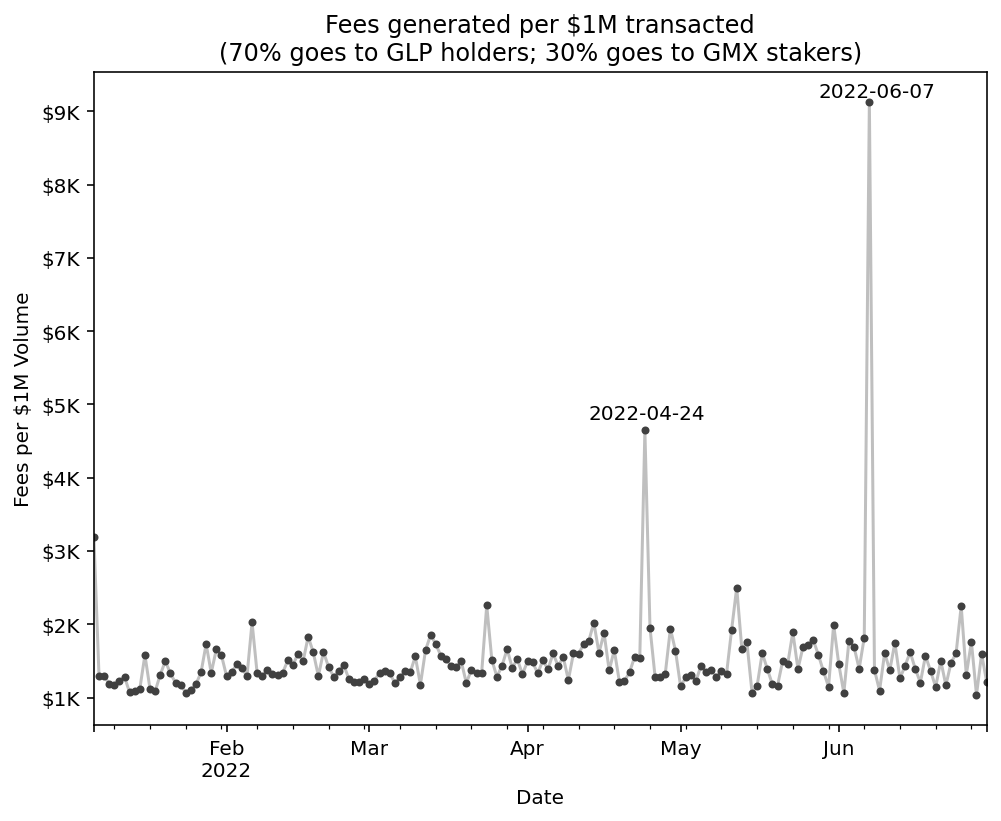

In [13]:
ax = fees_per_milvolume.plot(
    **plot_params, 
    title="Fees generated per $1M transacted\n(70% goes to GLP holders; 30% goes to GMX stakers)",
    ylabel='Fees per $1M Volume')
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax.yaxis.set_major_formatter(formatter)
ax.text('2022-05-28', 9.2e3, '2022-06-07')
ax.text('2022-04-13', 4.8e3, '2022-04-24')
plt.savefig(os.path.join(save_fig_dir, 'fees_per_mil_volume.png'), dpi=300);

In [14]:
avg = np.mean(fees_per_milvolume)
ste = st.sem(fees_per_milvolume, ddof=0) # same as std / sqrt(n), do not use the default ddof=1
ci = st.norm.interval(alpha=.95, loc=avg, scale=ste)
print("For every $1M transacted, we can expect, with 95% confidence, the platform to generate between ${:.0f} and ${:.0f} fees.".format(ci[0], ci[1]))
print("Let's take the middle point, ${:.0f}. Then ${:.0f} goes to GLP holders, and ${:.0f} goes to GMX stakers.".format(avg, avg*.7, avg*.3))

For every $1M transacted, we can expect, with 95% confidence, the platform to generate between $1411 and $1613 fees.
Let's take the middle point, $1512. Then $1059 goes to GLP holders, and $454 goes to GMX stakers.


## Volume Growth

In [15]:
yvar = 'total_volume'

### Daily

In [16]:
y = df_daily.loc[:, yvar]   # extract target
dd = fit_linreg(X_daily, y) # fit linear trend line, returns a dictionary
yhat = dd['yhat']
slope = dd['slope']

intercept: 96737475.908949 slope: -367543.216913378


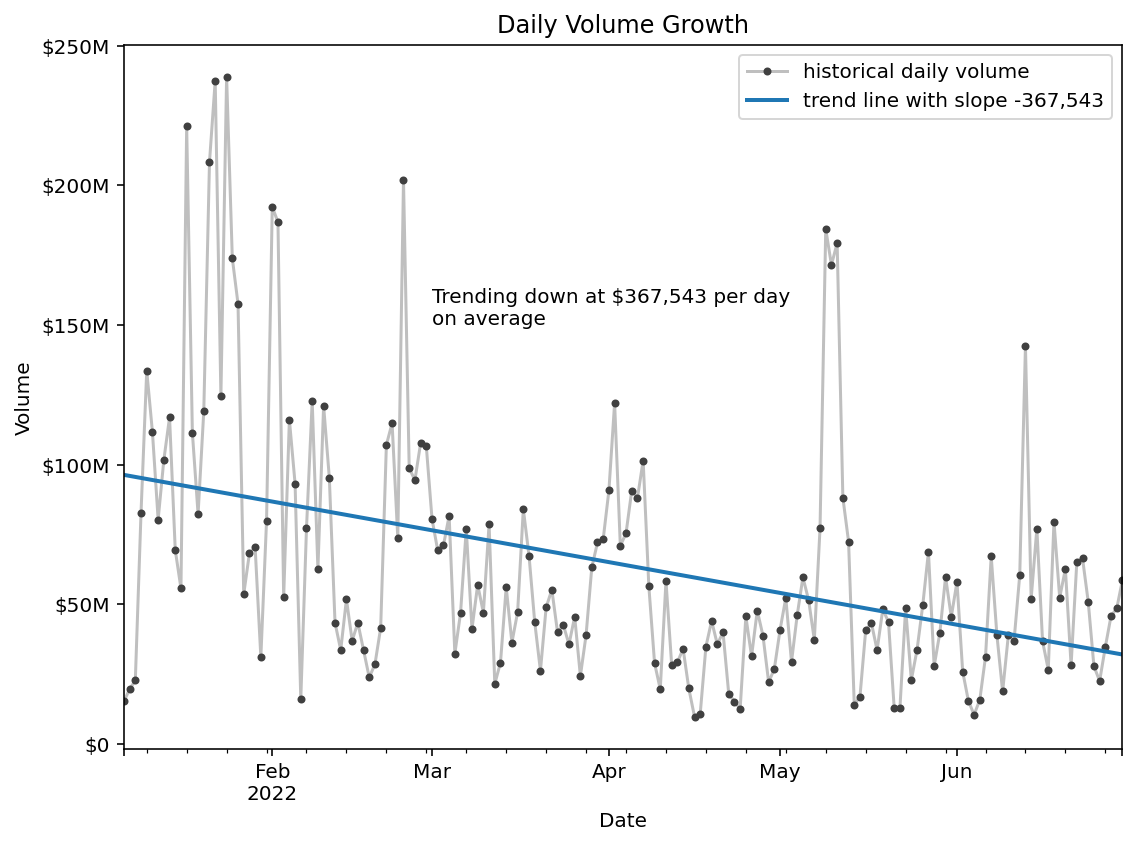

In [17]:
ax = plot_timeseries_with_trendline(
    y, yhat, title='Daily Volume Growth', ylabel='Volume', 
    ytru_legend='historical daily volume', yhat_legend="trend line with slope {:,.0f}".format(slope))
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax.yaxis.set_major_formatter(formatter)
ax.text('2022-03-01', 150e6, "Trending down at ${:,.0f} per day\non average".format(abs(slope)))
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(save_fig_dir, 'daily_volume_growth_trend.png'), dpi=300);

### Weekly

In [18]:
y = df_weekly.loc[:, yvar]   # extract target
dd = fit_linreg(X_weekly, y) # fit linear trend line
yhat = dd['yhat']
slope = dd['slope']

intercept: 648967019.5317488 slope: -15875213.374624554


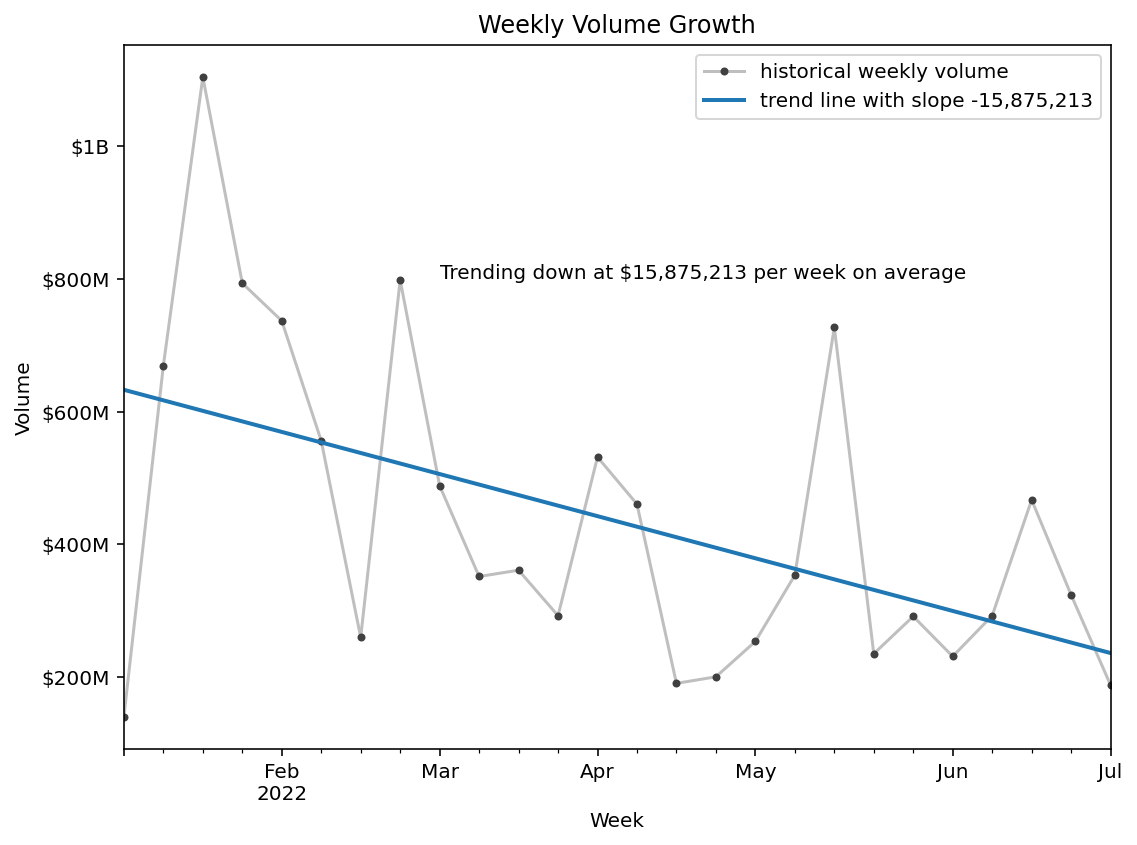

In [19]:
ax = plot_timeseries_with_trendline(
    y, yhat, title='Weekly Volume Growth', ylabel='Volume', 
    ytru_legend='historical weekly volume', yhat_legend="trend line with slope {:,.0f}".format(slope))
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax.yaxis.set_major_formatter(formatter)
ax.text('2022-03-01', 800e6, "Trending down at ${:,.0f} per week on average".format(abs(slope)))
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(save_fig_dir, 'weekly_volume_growth_trend.png'), dpi=300);

## Fee Growth

In [20]:
yvar = 'total_fees'

### Daily

In [21]:
# extract target
y = df_daily.loc[:, yvar]

# fit linear trend line
dd = fit_linreg(X_daily, y) 
yhat = dd['yhat']
slope = dd['slope']

intercept: 120943.82115905345 slope: -322.2329740212274


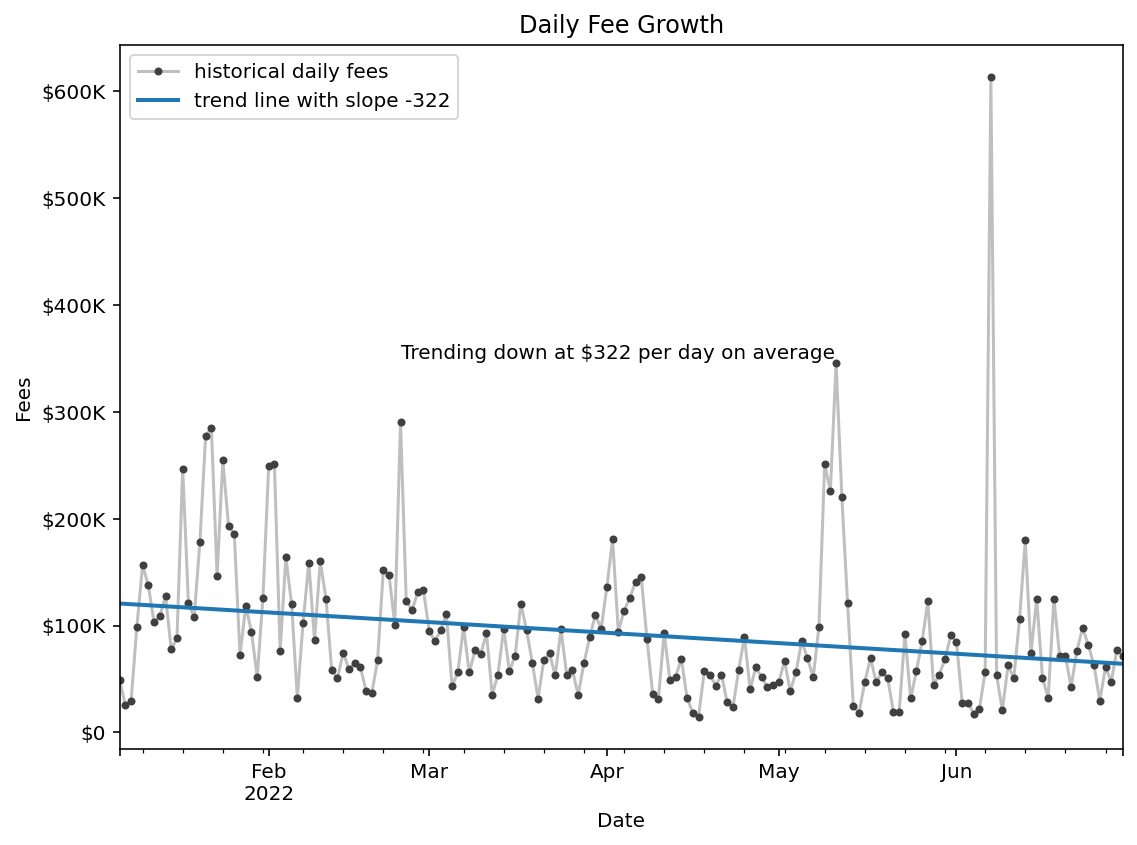

In [22]:
ax = plot_timeseries_with_trendline(
    y, yhat, title='Daily Fee Growth', ylabel='Fees', 
    ytru_legend='historical daily fees', yhat_legend="trend line with slope {:,.0f}".format(slope))
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True))
ax.yaxis.set_major_formatter(formatter)
ax.text('2022-02-24', 350_000, "Trending down at ${:,.0f} per day on average".format(abs(slope)))
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(save_fig_dir, 'daily_fee_growth_trend.png'), dpi=300);

### Weekly

In [23]:
# extract target
y = df_weekly.loc[:, yvar]

# fit linear trend line
dd = fit_linreg(X_weekly, y) 
yhat = dd['yhat']
slope = dd['slope']

intercept: 809905.7620753739 slope: -13648.256676128061


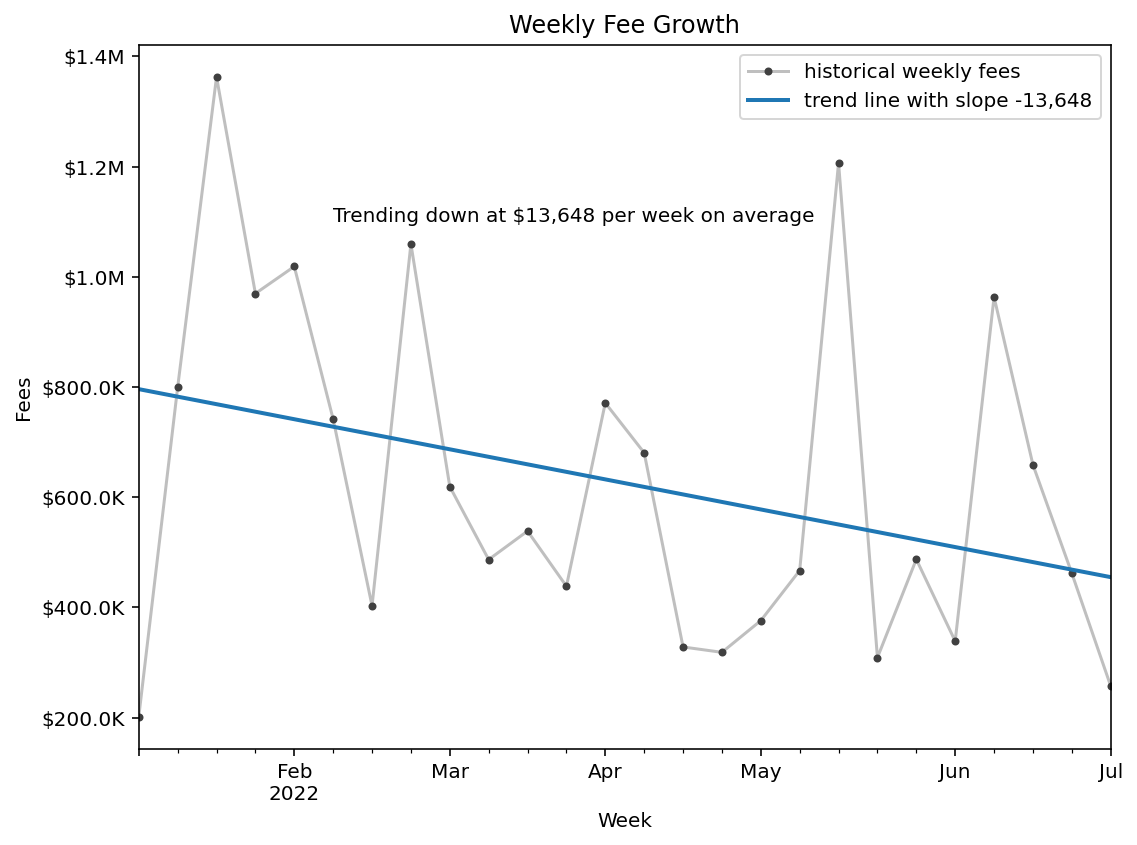

In [24]:
ax = plot_timeseries_with_trendline(
    y, yhat, title='Weekly Fee Growth', ylabel='Fees', 
    ytru_legend='historical weekly fees', yhat_legend="trend line with slope {:,.0f}".format(slope))
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=1))
ax.yaxis.set_major_formatter(formatter)
ax.text('2022-02-10', 1.1e6, "Trending down at ${:,.0f} per week on average".format(abs(slope)))
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(save_fig_dir, 'weekly_fee_growth_trend.png'), dpi=300);